# Full revision analysis

## List of work to be performed:
1. Supplementary figure showing incorrect inform tumor segmentation and NKT cells 
2. Supplementary figure with zoom-in images of individual cells from inForm and TME-Analyzer in an image with high disagreement 
3. Incorporation of DeepCell into TME-Analyzer 
4. Reorganize the MonteCarlo trials 
5. Supplementary table 6 with full ranking of parameters and discovery/validation p values if top n parameters were used instead. 
6. Generate forest plot for 4E 
7. Build classifier based on train-test split of discovery cohort. Try 16-47, 32-31, 47-16 splits. 
8. ? It is significant amount of work, but since both reviewers mention is, I can train a random forest on the original dataset and report it ? 

## 4. Reorganize the MonteCarlo trials 
We now provide a zip folder consisting of a 

4.1 .csv file listing the classifier parameters, 

4.2 a .txt file listing the patient split to test-train groups and 

4.3 the classifier performance, and 

4.4 a .png file plotting the Kaplan-Meier curves of patient groups; per classifier (a total of 3000 files, 70Mb).

task 4.2 & 4.3:

In [26]:
import pandas as pd
import numpy as np
import os
import shutil

Classifier_folder = "E:/Desktop_backup_20231031/Desktop/TME-Analyzer_the_manuscript/all_ML_approaches/v2/trials_20201202/first_1000/"
output_folder = "E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task4/"
patient_lookup = pd.read_excel("E:/Moved from E/TME-Analyzer_the_manuscript/20211129_TME-Analyzer/data_analysis/reproduction_of_old_analysis/20230712/discovery_data.xlsx", engine='openpyxl')
patient_lookup = patient_lookup.set_index(patient_lookup.keys()[0]).iloc[:,0]
# print(patient_lookup)
px_size = 0.4999
classifier_files = np.sort([i for i in os.listdir(Classifier_folder) if (i[-4:] == '.txt') & ('classifier_2020' in i)])
n_i = 0
for n_i in range(1000):
    file_name = Classifier_folder + classifier_files[n_i]
    with open(file_name,'r') as f:
        lines = f.readlines()
    with open(output_folder + 'classifier_' + f'{n_i+1:04d}' + '.txt','w') as f:
        for line in lines:
            for i in patient_lookup.index:
                # print(i)
                # print(line,type(line))
                if str(i) in line:
                    line = line.replace(str(i),str(patient_lookup.loc[i]))
            # print(line)
            f.write(line)
        # print(lines)

task 4.1

In [33]:
for n_i in range(1000):
# n_i = 0
    file_name = Classifier_folder + classifier_files[n_i].replace('.txt','.xls')

    px_size_dora = 0.4999
    classifier_frame = pd.read_excel(file_name)

    classifier_frame_new = pd.DataFrame(classifier_frame[['mean (good prognosis)', 'mean (bad prognosis)','p-value','used for classifier?']])
    classifier_frame_new.index = classifier_frame['Unnamed: 0']#,columns = ['mean (good prognosis)', 'mean (bad prognosis)'])
    px_size_cols = ['mean (good prognosis)', 'mean (bad prognosis)']
    for i in classifier_frame_new.index:
        if 'area' in i:
            classifier_frame_new.loc[i,px_size_cols] = classifier_frame_new.loc[i,px_size_cols]*px_size_dora*px_size_dora
        elif 'density' in i:
            classifier_frame_new.loc[i,px_size_cols] = classifier_frame_new.loc[i,px_size_cols]/px_size_dora/px_size_dora

    new_index = []
    for i in classifier_frame_new.index:
        if 'found' in i:
            new_index.append(i[:i.find('found')-1])
        else:
            new_index.append(i[:i[::-1].find('ni')*-1-3])
    classifier_frame_new.index = new_index

    classifier_frame_new.to_excel(output_folder + 'classifier_' + f'{n_i+1:04d}' + '.xls')

task 4.4

In [34]:
for n_i in range(1000):
    shutil.copy(Classifier_folder + classifier_files[n_i].replace('.txt','_os.png'), output_folder + 'classifier_' + f'{n_i+1:04d}' + '.png')

## 1. Supplementarty figure showing incorrect inform tumor segmentation and NKT cells
Stepwise approach;
1.2. Find an image with the maximum NKT presence, and present it.

In [1]:
import os
import pandas as pd
import numpy as np
px_size = 0.4999

automated_folder = 'E:/Moved from E/TME-Analyzer_the_manuscript/20211129_TME-Analyzer/data tables/'
inform_folder = 'E:/Moved from E/Dora effector/data_tables_inform/'
output_folder = "E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task1/"

phenos = ['CD20','CD3','CD3 CD8','CD56','CD68','CK','other','All']

tissues = ['All', 'Stroma', 'Tumor']

os.chdir(automated_folder)
auto_xls = os.listdir()
auto_xls = [i for i in auto_xls if i[-4:] == '.xls']
MSI_names_temp = [i[:i.find(']')+1] for i in auto_xls]
MSI_names = []
MSI_names_excluded = []
for MSI in MSI_names_temp:
    try:
        inform_data = pd.read_csv(inform_folder + MSI + '_cell_seg_data_summary.txt', sep='/t')
        MSI_names.append(MSI)
    except:
        MSI_names_excluded.append(MSI)

phenos = ['NKT']

tissues = ['All', 'Stroma', 'Tumor']
analysis_methods = ['auto']
panda_cols = []
panda_cols.append('location')
for pheno in phenos:
    for tissue in tissues:
        for method in analysis_methods:
            panda_cols.append('number of ' + pheno + ' in ' + tissue + ' found by ' + method + ' analysis')
            panda_cols.append('density of ' + pheno + ' in ' + tissue + ' found by ' + method + ' analysis')

data_frame = pd.DataFrame(index = MSI_names_temp, columns = panda_cols)

for n_f, MSI in enumerate(MSI_names_temp):
    auto_data = pd.read_excel(MSI + '_component_data.xls')
    if 'border' in inform_data['Path'][0]:
        data_frame.loc[MSI]['location'] = 'border'
    elif 'center' in inform_data['Path'][0]:
        data_frame.loc[MSI]['location'] = 'center'
    for tissue in tissues:
        if tissue == 'All':
            auto_of_interest = [i for i,j in enumerate(auto_data['Segments'].to_numpy()) if tissue in j]
        else:
            auto_of_interest = [i for i,j in enumerate(auto_data['Segments'].to_numpy()) if tissue + '+'  in j]
        auto_of_interest = auto_data.iloc[auto_of_interest,:]
        tissue_area_auto = np.sum(auto_of_interest['Cell Area'])
        for pheno in phenos:
            if tissue_area_auto > 0 :
                pheno_of_interest = auto_of_interest['Phenotypes'].to_numpy()
                if pheno == 'NKT':
                    pheno_of_interest = [i for i,j in enumerate(pheno_of_interest) if (('CD3+' in j) & ('CD56+' in j))]
                data_frame.loc[MSI]['density of ' + pheno + ' in ' + tissue + ' found by auto analysis'] = len(pheno_of_interest)/tissue_area_auto*1000000
                data_frame.loc[MSI]['number of ' + pheno + ' in ' + tissue + ' found by auto analysis'] = len(pheno_of_interest)
            else:
                data_frame.loc[MSI]['density of ' + pheno + ' in ' + tissue + ' found by auto analysis'] = 0
                data_frame.loc[MSI]['number of ' + pheno + ' in ' + tissue + ' found by auto analysis'] = 0

data_frame.to_excel(output_folder + 'NKT_quantification.xls')

In [27]:
import shutil
output_folder = "E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task1/NKT_workplaces/"
pickle_folder = 'E:/Moved from E/TME-Analyzer_the_manuscript/20211129_TME-Analyzer/workplaces/'
images_of_interest = []
for i in data_frame.index:
    try:
        if data_frame.loc[i,'number of NKT in All found by auto analysis']>10:
            images_of_interest.append(i)
    except:
        pass
# [i for i in data_frame.index if data_frame.loc[i,'number of NKT in All found by auto analysis']>10]
for i in images_of_interest:
    shutil.copy(pickle_folder+i+'_component_data.pickle',output_folder+i+'_component_data.pickle')

NameError: name 'data_frame' is not defined

In [ ]:
import skimage.io
import pickle
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
pickle_folder = 'E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task1/NKT_workplaces/modified/'
selected_file = 'DH-93-07884_[54144,5272]_component_data.pickle'
pickle_data = pickle.load(open(pickle_folder + selected_file, "rb"))
# skimage.io.imread(filename)

In [ ]:
Cell_props = pickle_data['Cell_props']
x1, x2, y1, y2 = 900,1200,500,700
nkt_cells = [i for i in Cell_props.index if 'NKT' in Cell_props.loc[i,'Phenotypes']]
CD3_cells = [i for i in Cell_props.index if 'CD3+' in Cell_props.loc[i,'Phenotypes']]
CD56_cells = [i for i in Cell_props.index if 'CD56+' in Cell_props.loc[i,'Phenotypes']]
nkt_locs = Cell_props.loc[nkt_cells,'Cell Centroid'].to_numpy()
nkt_locs_crop = []
for i in nkt_locs:
    if (i[0] > y1) & (i[0] < y2) & (i[1] > x1) & (i[1] < x2):
        nkt_locs_crop.append([i[0]-y1,i[1]-x1])

CD3_locs = Cell_props.loc[CD3_cells,'Cell Centroid'].to_numpy()
CD3_locs_crop = []
for i in CD3_locs:
    if (i[0] > y1) & (i[0] < y2) & (i[1] > x1) & (i[1] < x2):
        CD3_locs_crop.append([i[0]-y1,i[1]-x1])

CD56_locs = Cell_props.loc[CD56_cells,'Cell Centroid'].to_numpy()
CD56_locs_crop = []
for i in CD56_locs:
    if (i[0] > y1) & (i[0] < y2) & (i[1] > x1) & (i[1] < x2):
        CD56_locs_crop.append([i[0]-y1,i[1]-x1])


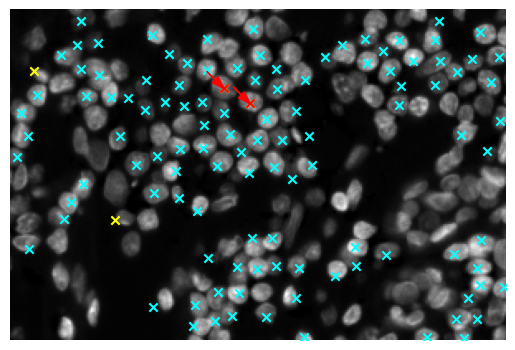

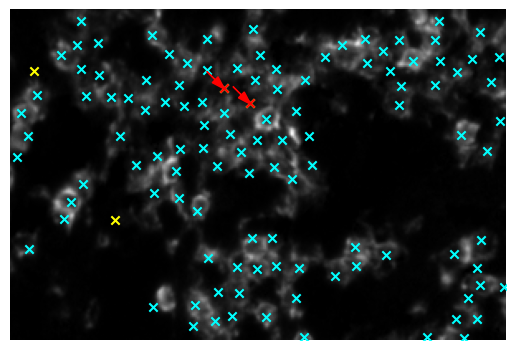

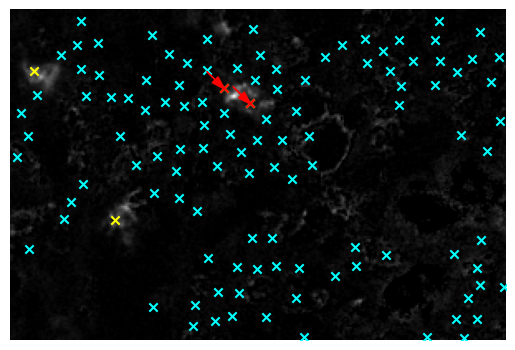

In [ ]:
for i in [0,3,5]:
    plt.figure()
    plt.imshow(pickle_data['im_raw'][y1:y2,x1:x2,i])
    plt.axis('off')
    plt.set_cmap('gray')
    for i in CD3_locs_crop:
        # plt.arrow(i[1]-6,i[0]-6,2,2,color='cyan',head_width=2,head_length=4,head_starts_at_zero=True)
        plt.scatter(i[1],i[0],marker='x',color='cyan')
    for i in CD56_locs_crop:
        # plt.arrow(i[1]-6,i[0]-6,2,2,color='yellow',head_width=2,head_length=4,head_starts_at_zero=True)
        plt.scatter(i[1],i[0],marker='x',color='yellow')
    for i in nkt_locs_crop:
        plt.scatter(i[1],i[0],marker='x',color='red')
        plt.arrow(i[1]-13,i[0]-13,5,5,color='red',head_width=5,head_length=8,head_starts_at_zero=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


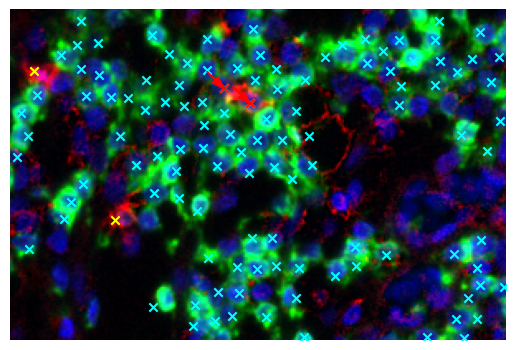

In [ ]:
plt.figure()
to_plot = pickle_data['im_raw'][y1:y2,x1:x2,[5,3,0]]/4
to_plot[:,:,2] /= 10
to_plot[:,:,1] /= 2
plt.imshow(to_plot)
plt.axis('off')
plt.set_cmap('gray')
for i in CD3_locs_crop:
    # plt.arrow(i[1]-6,i[0]-6,2,2,color='cyan',head_width=2,head_length=4,head_starts_at_zero=True)
    plt.scatter(i[1],i[0],marker='x',color='cyan')
for i in CD56_locs_crop:
    # plt.arrow(i[1]-6,i[0]-6,2,2,color='yellow',head_width=2,head_length=4,head_starts_at_zero=True)
    plt.scatter(i[1],i[0],marker='x',color='yellow')
for i in nkt_locs_crop:
    plt.scatter(i[1],i[0],marker='x',color='red')
    plt.arrow(i[1]-13,i[0]-13,5,5,color='red',head_width=5,head_length=8,head_starts_at_zero=True)

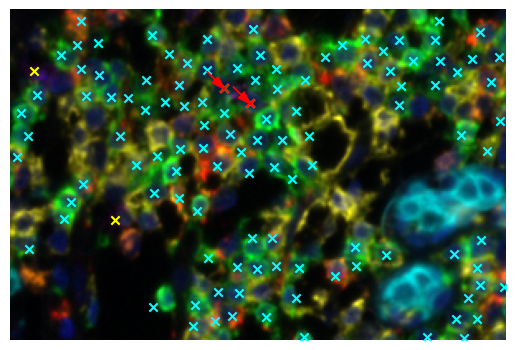

In [ ]:
to_plot = skimage.io.imread("E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task1/inForm_output_images/" + 
                            selected_file.replace("_component_data.pickle","_composite_image.tif"))
to_plot = to_plot[y1:y2,x1:x2,:]
plt.imshow(to_plot)
plt.axis('off')
plt.set_cmap('gray')
for i in CD3_locs_crop:
    # plt.arrow(i[1]-6,i[0]-6,2,2,color='cyan',head_width=2,head_length=4,head_starts_at_zero=True)
    plt.scatter(i[1],i[0],marker='x',color='cyan')
for i in CD56_locs_crop:
    # plt.arrow(i[1]-6,i[0]-6,2,2,color='yellow',head_width=2,head_length=4,head_starts_at_zero=True)
    plt.scatter(i[1],i[0],marker='x',color='yellow')
for i in nkt_locs_crop:
    plt.scatter(i[1],i[0],marker='x',color='red')
    plt.arrow(i[1]-13,i[0]-13,5,5,color='red',head_width=5,head_length=8,head_starts_at_zero=True)

In [35]:
# import pandas as pd
inform_analysis = pd.read_csv("E:/Moved from E/Dora effector/data_tables_inform/full_cohort/" + 
                              selected_file.replace("_component_data.pickle","_cell_seg_data_summary.txt"),sep='\t')
CD3_locs_crop_inform = []
CD56_locs_crop_inform = []
inform_analysis.keys()
CD8_cells_x = [i for i in inform_analysis.index if inform_analysis.loc[i,'Phenotype'] == 'CD3 CD8']
inform_analysis.loc[CD8_cells_x]
# CD4_cells_x = [i for i in Cell_props.index if 'CD3+' in Cell_props.loc[i,'Phenotypes']]
# CD56_cells_x = [i for i in Cell_props.index if 'CD56+' in Cell_props.loc[i,'Phenotypes']]
# nkt_locs = Cell_props.loc[nkt_cells,'Cell Centroid'].to_numpy()
# nkt_locs_crop = []
# for i in nkt_locs:
#     if (i[0] > y1) & (i[0] < y2) & (i[1] > x1) & (i[1] < x2):
#         nkt_locs_crop.append([i[0]-y1,i[1]-x1])

# CD3_locs = Cell_props.loc[CD3_cells,'Cell Centroid'].to_numpy()
# CD3_locs_crop = []
# for i in CD3_locs:
#     if (i[0] > y1) & (i[0] < y2) & (i[1] > x1) & (i[1] < x2):
#         CD3_locs_crop.append([i[0]-y1,i[1]-x1])

# CD56_locs = Cell_props.loc[CD56_cells,'Cell Centroid'].to_numpy()
# CD56_locs_crop = []
# for i in CD56_locs:
#     if (i[0] > y1) & (i[0] < y2) & (i[1] > x1) & (i[1] < x2):
#         CD56_locs_crop.append([i[0]-y1,i[1]-x1])

# # to_plot = to_plot[500:700,900:1200,:]
# # plt.imshow(to_plot)
# # plt.axis('off')
# # plt.set_cmap('gray')
# # for i in CD3_locs_crop:
# #     # plt.arrow(i[1]-6,i[0]-6,2,2,color='cyan',head_width=2,head_length=4,head_starts_at_zero=True)
# #     plt.scatter(i[1],i[0],marker='x',color='cyan')
# # for i in CD56_locs_crop:
# #     # plt.arrow(i[1]-6,i[0]-6,2,2,color='yellow',head_width=2,head_length=4,head_starts_at_zero=True)
# #     plt.scatter(i[1],i[0],marker='x',color='yellow')
# # for i in nkt_locs_crop:
# #     plt.scatter(i[1],i[0],marker='x',color='red')
# #     plt.arrow(i[1]-13,i[0]-13,5,5,color='red',head_width=5,head_length=8,head_starts_at_zero=True)

,Path,Sample Name,Tissue Category,Phenotype,Cell ID,Total Cells,Tissue Category Area (pixels),Cell Density (per megapixel),Cell X Position,Cell Y Position,...,"Entire Cell Autofluorescence Std Dev (Normalized Counts, Total Weighting)","Entire Cell Autofluorescence Total (Normalized Counts, Total Weighting)",Lab ID,Slide ID,TMA Sector,TMA Row,TMA Column,TMA Field,Confidence,inForm 2.4.6663.14071
2,D:\Data\Vectra3\triple neg borst;effectorpanne...,"DH-93-07884_[54144,5272].im3",Tumor,CD3 CD8,all,45,463480,97.1,NaN,NaN,...,1.469,27177.391,NaN,DH-93-07884,0,0,0,0,NaN,NaN
10,D:\Data\Vectra3\triple neg borst;effectorpanne...,"DH-93-07884_[54144,5272].im3",Stroma,CD3 CD8,all,312,833348,374.4,NaN,NaN,...,1.154,201717.244,NaN,DH-93-07884,0,0,0,0,NaN,NaN
18,D:\Data\Vectra3\triple neg borst;effectorpanne...,"DH-93-07884_[54144,5272].im3",wholes,CD3 CD8,all,0,48532,0.0,NaN,NaN,...,0.000,0.000,NaN,DH-93-07884,0,0,0,0,NaN,NaN
26,D:\Data\Vectra3\triple neg borst;effectorpanne...,"DH-93-07884_[54144,5272].im3",All,CD3 CD8,all,357,1345360,265.4,NaN,NaN,...,1.196,228894.635,NaN,DH-93-07884,0,0,0,0,NaN,NaN
